In [1]:
from multitask_dataset import SingerMultiTaskDataset
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch
from models import HuBERTMultiHead
import pandas as pd
from tqdm import tqdm
import numpy as np
import os
import csv

/home/maximos/miniconda3/envs/torchaudio/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# data folders
train_audio_folder = '/media/maindisk/maximos/data/melos_singers/Rebetika_vowels/train/'
test_audio_folder = '/media/maindisk/maximos/data/melos_singers/Rebetika_vowels/test/'
csv_path = '/media/maindisk/maximos/data/melos_singers/features/multitask_targets.csv'
# train_audio_folder = '/media/maximos/9C33-6BBD/data/melos_singers/Rebetika_vowels/train/'
# test_audio_folder = '/media/maximos/9C33-6BBD/data/melos_singers/Rebetika_vowels/test/'
# csv_path = '/media/maximos/9C33-6BBD/data/melos_singers/features/multitask_targets.csv'

batch_size = 8

# load csv
feats = pd.read_csv(csv_path, delimiter=',')
# keep feature list which will become the tasks
features_list = list(feats.columns)
# delete unnecessary columns
del(features_list[:2])

# keep number of outputs per task
task_labels_num_out = {}
for i in range(1, len(features_list)-3, 1):
    task_labels_num_out[features_list[i]] = 1
# add singer identification
task_labels_num_out['singer_id'] = feats['singer_id'].max()+1 # accounting for zero

# initialize model
model = HuBERTMultiHead(task_labels_num_out=task_labels_num_out)

# make datasets
training_data = SingerMultiTaskDataset(train_audio_folder, csv_path)
testing_data = SingerMultiTaskDataset(test_audio_folder, csv_path)

# make dataloaders
train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True, collate_fn=model.collate_fn)
test_loader = DataLoader(testing_data, batch_size=batch_size, shuffle=True, collate_fn=model.collate_fn)

You are using a model of type hubert to instantiate a model of type wav2vec2. This is not supported for all configurations of models and can yield errors.
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/hubert-base-ls960 and are newly initialized: ['encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
saved_model_path = '/media/maindisk/maximos/repos/singer_feature_multi_regression/saved_models/frozen_hubert/frozen_hubert.pt'
model.load_state_dict(torch.load(saved_model_path), strict=False)

<All keys matched successfully>

In [4]:
b = next(iter( test_loader ))

In [5]:
training_data[0]

{'input_values': array([-0.08967178, -0.19010347, -0.2083385 , ..., -0.00820476,
        -0.00176415,  0.00736174], dtype=float32),
 'labels': {'Unnamed: 0': 287,
  'names': 'ninou_u_4',
  'singer_id': 4,
  'Pitch': 0.7754291502648109,
  'SpectralCentroid': 0.35092921737166927,
  'SpectralSpread': 0.5033758122514298,
  'SpectralSkewness': 0.45104215554233057,
  'SpectralKurtosis': 0.12069832760379844,
  'SpectralFlatness': 0.0009205238960196318,
  'SpectralCrest': 0.5512284674624198,
  'SpectralSlope': 0.3793055638224495,
  'SpectralDecrease': 0.3983801121358673,
  'SpectralRollOff': 0.33619637513544615,
  'SpectralVariation': 1.0,
  'SpectralFlux': 0.6978128892136559,
  'HarmonicSpectralDeviation': 0.1739637397326696,
  'Tristimulus_1': 0.6937424899741716,
  'Tristimulus_2': 0.381731617603988,
  'Tristimulus_3': 0.04276276024942205,
  'HarmonicOddToEvenRatio': 0.04594380763834991,
  'Inharmonicity': 0.012539580815794317,
  'HarmonicEnergy': 0.5478845770114545,
  'NoiseEnergy': 0.60951

In [6]:
print(len(training_data))
for i in range( len( testing_data ) ):
    print(testing_data[i]['labels']['names'])

336
ninou_u_1
ninou_e_1
ninou_i_1
ninou_a_1
ninou_w_1
kazantzidis_e_1
kazantzidis_w_2
kazantzidis_w_3
kazantzidis_w_1
kazantzidis_a_2
kazantzidis_i_2
kazantzidis_a_1
kazantzidis_u_1
kazantzidis_i_1
kazantzidis_a_3
bithikotsis_e_6
bithikotsis_a_10
bithikotsis_u_4
bithikotsis_i_9
bithikotsis_w_8
keti_grei_a_16
keti_grei_e_10
keti_grei_i_10
keti_grei_a_17
keti_grei_u_8
keti_grei_e_11
keti_grei_w_9
bellou_a_1
bellou_w_1
bellou_u_1
bellou_i_1
bellou_e_1
kazantzidis_old_a_2
kazantzidis_old_e_1
kazantzidis_old_i_1
kazantzidis_old_w_1
kazantzidis_old_a_1
kazantzidis_old_u_1
tsaousakis_w_2
tsaousakis_e_1
tsaousakis_u_1
tsaousakis_i_3
tsaousakis_e_2
tsaousakis_i_1
tsaousakis_a_3
tsaousakis_a_2
tsaousakis_a_1
tsaousakis_w_1
tsaousakis_i_2


In [7]:
print(len(testing_data))
for i in range(10):
    b = next(iter( test_loader ))
    print(b[1]['names'])

49
['keti_grei_w_9', 'bithikotsis_e_6', 'ninou_w_1', 'kazantzidis_a_1', 'keti_grei_i_10', 'kazantzidis_i_2', 'bithikotsis_w_8', 'tsaousakis_i_3']
['kazantzidis_a_3', 'kazantzidis_i_2', 'bellou_i_1', 'tsaousakis_e_1', 'keti_grei_i_10', 'kazantzidis_w_3', 'bellou_w_1', 'bellou_e_1']
['kazantzidis_old_a_1', 'keti_grei_a_16', 'bithikotsis_u_4', 'ninou_w_1', 'keti_grei_u_8', 'ninou_i_1', 'tsaousakis_w_1', 'tsaousakis_a_3']
['keti_grei_a_17', 'bithikotsis_a_10', 'kazantzidis_old_i_1', 'kazantzidis_old_e_1', 'tsaousakis_i_2', 'keti_grei_u_8', 'kazantzidis_old_a_2', 'ninou_a_1']
['tsaousakis_e_2', 'kazantzidis_w_1', 'bithikotsis_e_6', 'tsaousakis_i_3', 'kazantzidis_old_a_2', 'kazantzidis_a_3', 'kazantzidis_i_2', 'kazantzidis_w_2']
['ninou_w_1', 'kazantzidis_e_1', 'bithikotsis_u_4', 'bithikotsis_e_6', 'kazantzidis_old_a_2', 'bithikotsis_i_9', 'tsaousakis_i_1', 'tsaousakis_w_2']
['tsaousakis_e_2', 'kazantzidis_a_3', 'tsaousakis_w_2', 'ninou_u_1', 'kazantzidis_i_1', 'tsaousakis_a_3', 'bithikotsis

In [8]:
y = model(
    audio_normalized=b[0]['input_values'],
    attention_mask=b[0]['attention_mask'],
    labels=b[1],
    output_attentions=False,
    output_hidden_states=True,
    return_dict=True
)

In [9]:
print(y.loss)
print(b[1]['names'])
print(y.logits['singer_id'])

tensor(2.1591, device='cuda:0', grad_fn=<AddBackward0>)
['kazantzidis_w_3', 'bithikotsis_i_9', 'ninou_w_1', 'kazantzidis_old_e_1', 'ninou_a_1', 'tsaousakis_a_2', 'keti_grei_i_10', 'ninou_e_1']
[tensor([[2.1558e-02, 1.5753e-02, 9.6235e-01, 7.4423e-06, 3.8896e-06, 3.2679e-04],
        [3.3598e-06, 4.5320e-01, 3.4004e-07, 1.8732e-08, 4.3750e-06, 5.4679e-01],
        [3.2239e-05, 1.5531e-07, 1.6579e-09, 9.9996e-01, 1.2131e-05, 1.8756e-10],
        [7.3761e-08, 2.3951e-10, 5.1183e-03, 3.9105e-20, 1.0962e-13, 9.9488e-01],
        [7.4518e-01, 2.1561e-05, 5.2821e-03, 8.1325e-03, 2.4138e-01, 9.5645e-16],
        [1.9292e-04, 9.1984e-01, 7.8156e-02, 1.8692e-08, 1.1092e-06, 1.8126e-03],
        [1.3539e-13, 1.4578e-06, 5.5602e-14, 1.0000e+00, 4.6036e-12, 1.2152e-21],
        [1.3226e-04, 3.5402e-05, 2.6441e-09, 3.1461e-02, 1.5961e-08, 9.6837e-01]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)]


In [10]:
h = y.hidden_states['hubert']
p = y.hidden_states['projectors']

In [11]:
print(p)

{'Pitch': tensor([[-0.5994, -0.3267, -0.6515,  ..., -0.3768,  0.0445, -1.0726],
        [-0.7246, -0.4508, -0.7033,  ..., -0.1416, -0.0264, -1.2603],
        [-0.6773, -0.5112, -0.7375,  ..., -0.6285,  0.2180, -1.1940],
        ...,
        [-0.6472, -0.2281, -0.7746,  ..., -0.6862,  0.2283, -1.1310],
        [-0.6195, -0.6620, -0.5886,  ...,  0.3211,  0.2705, -1.0729],
        [-0.7326, -0.4145, -0.6701,  ..., -0.3628, -0.0948, -1.4423]],
       device='cuda:0', grad_fn=<AddmmBackward0>), 'SpectralCentroid': tensor([[ 0.4872,  0.8303, -1.0993,  ..., -1.8277, -0.1210, -0.2811],
        [ 0.2673, -0.1403, -0.9061,  ..., -1.4674, -0.4933, -0.5848],
        [ 0.3519,  0.6112, -0.7750,  ..., -1.5244, -0.0695, -0.2960],
        ...,
        [-0.4644, -0.1581, -0.9579,  ..., -1.5759, -0.3477, -0.1064],
        [ 0.0308, -0.2610, -0.8922,  ..., -1.3883, -0.5094, -0.5562],
        [-0.0469, -0.0523, -0.9290,  ..., -1.6211, -0.3276, -0.5231]],
       device='cuda:0', grad_fn=<AddmmBackward0>), 

In [26]:
color_values = {}
hidden_states = []
projectors = {}

with torch.no_grad():
    for b in train_loader:
        y = model(
            audio_normalized=b[0]['input_values'],
            attention_mask=b[0]['attention_mask'],
            labels=b[1],
            output_attentions=False,
            output_hidden_states=True,
            return_dict=True
        )
        hidden_states.append( y.hidden_states['hubert'].cpu().mean(axis=1).numpy() )
        for k in y.logits.keys():
            # color_values.setdefault(k, []).append( y.logits[k][0].cpu().numpy() )
            color_values.setdefault(k, []).append( np.array(b[1][k]) )
            projectors.setdefault(k, []).append( y.hidden_states['projectors'][k].cpu().numpy() )
    # for b in test_loader:
    #     y = model(
    #         audio_normalized=b[0]['input_values'],
    #         attention_mask=b[0]['attention_mask'],
    #         labels=b[1],
    #         output_attentions=False,
    #         output_hidden_states=True,
    #         return_dict=True
    #     )
    #     hidden_states.append( y.hidden_states['hubert'].cpu().mean(axis=1).numpy() )
    #     for k in y.logits.keys():
    #         # color_values.setdefault(k, []).append( y.logits[k][0].cpu().numpy() )
    #         color_values.setdefault(k, []).append( np.array(b[1][k]) )
    #         projectors.setdefault(k, []).append( y.hidden_states['projectors'][k].cpu().numpy() )

In [27]:
np.hstack( color_values['Pitch'] ).shape

(336,)

In [28]:
y.logits[k][0].cpu().numpy()

array([[4.0010626e-08, 2.9629207e-04, 9.9970227e-01, 6.4328172e-21,
        1.4088396e-06, 1.2395683e-08],
       [3.6560596e-05, 3.9235331e-08, 2.4761443e-10, 1.6493216e-06,
        9.9996173e-01, 3.8161096e-11],
       [4.8052340e-07, 1.4311459e-09, 9.9999952e-01, 1.2934277e-10,
        1.9609129e-11, 3.7410622e-08],
       [2.5186746e-09, 3.2508810e-10, 3.0347558e-06, 2.1573456e-10,
        1.2617703e-12, 9.9999702e-01],
       [2.6863054e-06, 6.9485749e-03, 9.9213761e-01, 2.9192174e-10,
        5.2298422e-13, 9.1110327e-04],
       [1.9928362e-05, 3.0578942e-10, 1.1907204e-05, 1.2933648e-14,
        9.2259642e-15, 9.9996817e-01],
       [3.8304884e-09, 1.3139540e-04, 9.9986863e-01, 1.0808159e-13,
        1.9772737e-15, 1.3850906e-08],
       [2.3176317e-07, 9.9995983e-01, 3.8243638e-08, 2.1794631e-09,
        4.6973927e-09, 3.9991959e-05]], dtype=float32)

In [29]:
# hs_np = np.vstack(hidden_states)
# cv_np = {}
# for k in color_values.keys():
#     if k == 'singer_id':
#         cv_np[k] = np.argmax( np.vstack( color_values[k] ), axis=1 )
#     else:
#         cv_np[k] = np.vstack( color_values[k] )
hs_np = np.vstack(hidden_states)
cv_np = {}
for k in color_values.keys():
    cv_np[k] = np.hstack( color_values[k] )

In [30]:
print(hs_np.shape)
print(cv_np['singer_id'].shape)

(336, 768)
(336,)


In [31]:
from sklearn.manifold import TSNE

In [32]:
tsne = TSNE(n_components=2, learning_rate='auto',
            init='random', perplexity=30)
X_embedded = tsne.fit_transform(hs_np)

In [33]:
print(X_embedded.shape)

(336, 2)


In [34]:
import matplotlib.pyplot as plt

In [35]:
color_keys = list(cv_np.keys())

Text(0.5, 1.0, 'singer_id')

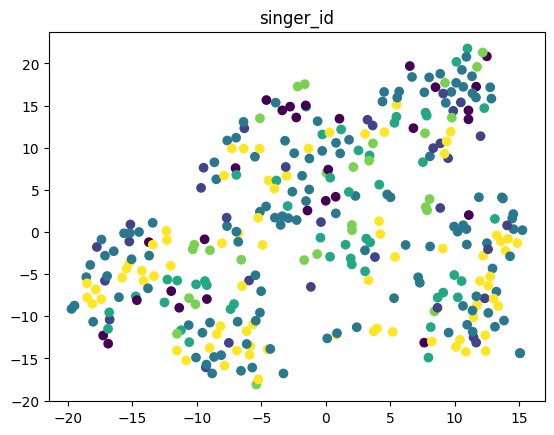

In [36]:
# col = color_keys[1]
col = 'singer_id'
plt.scatter( X_embedded[:,0], X_embedded[:,1], c=cv_np[col] )
plt.title(col)

In [37]:
# make numpy for all projectors
projectors_np = {}
projectors_tsne = {}
for k in projectors.keys():
    projectors_np[k] = np.vstack(projectors[k])
    projectors_tsne[k] = tsne.fit_transform(projectors_np[k])

In [38]:
os.makedirs('figs', exist_ok=True)

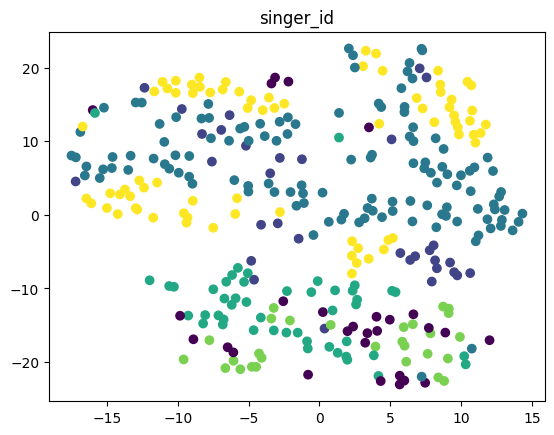

In [39]:
for k in projectors.keys():
    X_embedded = projectors_tsne[k]
    plt.clf()
    plt.scatter( X_embedded[:,0], X_embedded[:,1], c=cv_np[k] ) # c=cv_np['singer_id'] )
    plt.title(k)
    plt.savefig('figs/' + k + '.png', dpi=300)